In [16]:
# Processing
import json
from html.parser import HTMLParser
from bs4 import BeautifulSoup

# Data Science
import pandas as pd
import matplotlib.pyplot as plt

# Introduction to Digital Forensics - Assignment 1

In this assignment, we investigate a black market and the items offered in that black market. We decided to choose the Silk Road for our investigation.

After downloading the TOR browser, we opened the website and looked for the products. We realized that it would take a long time to write down all the information so we decided to write a couple of scripts to helps us save the information

Contributors:
- Carlos de Bourbon de Parme
- Vera Schockemöhle
- Floor Schutrups
- Jelle Hulter
- Nora Yigit
- Arda Öz

## Motivation and goals
During our lecture, we have been shown an example of a black market on the dark web. In this exercise, we are trying to get more familiar with the black market. Hence, our goal is to answer the following three research questions:

1) How does the black market work exactly?
2) Which items are offered on the black market?
3) What is the legality of the items offered on the black market?

## Methodology
First, we looked for a black market to investigate. After trying some links on the websites given with the assignment, we noticed that they were really slow and hard to connect to. One of the group members were familiar with a bigger black market in the early days of the dark web, which had already been seized by the international intelligence agencies before, namely the [Silk Road](https://en.wikipedia.org/wiki/Silk_Road_(marketplace)). From the Wikipedia page about the marketplace, we found an onion URL which lead us to Silk Road 4, although it was mentioned on the Wikipedia page as defunct. This "defunct" link lead us to the following onion URL:
http://silkroad22gtemddxbbfxe57xmb4mxgcwnbwbvarpbghsseluxwdnvyd.onion/

We created an account and took a look at what items the market listed. We immediately saw that many of the categories consisted of drugs, but there were also a few other categories selling accounts, payment information or eBooks.

Using the JavaScript-console of the Tor browser, we were able to retrieve the HTML contents of 15 pages of the listings easily, resulting in a total of 165 entries.

```js
let request = function(i) {
    var xmlHttp = new XMLHttpRequest();
    xmlHttp.open( "GET", "http://silkroad22gtemddxbbfxe57xmb4mxgcwnbwbvarpbghsseluxwdnvyd.onion/?road=&reqpage="+i, false ); // false for synchronous request
    xmlHttp.send( null );
    return xmlHttp.responseText;
}

let requestAll = function() {
    let response = []
    for(let i = 0; i < 15; i++) {
        response.push(request(i));
    }
    return response;
}

```

After executing `requestAll()`, we received a JSON array of 15 strings with in all of them an HTML representation of each of the pages loaded. We could copy this from the console into a JSON file, such that we could analyze it below in this notebook using Pyhton.

## Acquiring the Data

After exporting the HTML contents, we wrote a Python script to parse the information about the contents from the HTML strings:

In [17]:
read_from_file = 'html_contents.json'
write_to_file  = 'products.csv'

with open(read_from_file, encoding="utf8") as f:
    data = json.load(f)

with open(write_to_file, 'w', encoding="utf8") as f:
    f.write("name;vendor;category;shippingCountry;dollars;positiveRating;negativeRating;rating\n")

    for page in data:
        parsed = BeautifulSoup(page)
        products = parsed.find_all('div', {'style': 'min-width:300px'})  
        for product in products:
            
            ss = []
            ss.append(product.find_all('a')[0].get_text()) #The name of the product
            ss.append(product.find('span', {'id': 'ah_name'}).a.get_text()) #The vendor name
            ss.append(product.find_all('a')[3].get_text()) #The category
            ss.append(product.find('span', {'id': 'ah_ships'}).get_text()) #The shipping country
            ss.append(product.find_all('b')[-1].get_text().split()[0][1:]) #The price of the product listed in USD
            ratings = product.find('span', {'id': 'ah_score'}).get_text().split(', ') #An array of positive ratings, negative ratings, and it's ratio of positive ratings
            ratings = [ratings[0][1:], ratings[1][1:], ratings[2][:-1]]
            ss.extend(ratings)
            ss = [s.strip() for s in ss]
            f.write("%s\n"%";".join(ss))

Once the code cell above is run, we now have a CSV file in our wokrking directory. We can load this file as a DataFrame to inspect its structure.

Users on GitHub may not be able to run the code cell above because we decided not to add the JSON-file to the GitHub repository, since it contains copies of an HTML document of a website. Run the JavaScript code on the Black Market yourselves if you want to retrieve this JSON-information.

In [7]:
df = pd.read_csv(write_to_file, delimiter=';')
df

,name,vendor,category,shippingCountry,dollars,positiveRating,negativeRating,rating
0,"LEVEL 1 - FULL Ounce $160 **Dutch, CandyLand**",DroDodo,Weed,United States,160,2485,0,100
1,12 x 250ug LSD tabs (stamps) - FREE SHIPPING,Streetlegend,LSD,Netherlands,65,1420,10,99
2,disneyplus account,levelup,Accounts,United States,10,1516,0,100
3,Blue Magic Uncut Cocaine 95% Pure Coke from Pe...,bluemagic,Cocaine,United Kingdom,75,18313,42,100
4,1GR ULTRA CLEAN QUALITY COCAINE 95% #1,ViceKings,Cocaine,Netherlands,60,18083,236,99
...,...,...,...,...,...,...,...,...
160,top brandedible skittles edibles 500 mg,levelup,Edibles,United States,10,1516,0,100
161,[AU✈AU] ♛FLASH SALE♛ 1 G MDMA – PURE HOLLAND I...,Hilfiger,MDMA,Australia,90,1970,5,100
162,1 Gram DMT Free Shipping,vintage,DMT,Netherlands,70,620,20,97
163,MASERATI 2CB 22MG PILLS XTC Ecstasy MDMA 2C-B ...,bluemagic,2C,United Kingdom,50,18313,42,100


## Labeling Legal or Illegal Items 

Before labeling the products, we observed that the website has seperated the drugs to different categories. We wanted to join all the drugs into a single category. To do this, we added another column to our dataframe called `main_category`:

In [8]:
non_drug_dictionary = {
    'Others': 'Others',
    'Concentrates': 'Concentrates',
    'CC/CVV': 'CC/CVV',
    'PayPal': 'PayPal',
    'Edibles': 'Edibles',
    'Mushrooms': 'Mushrooms',
    'Accounts': 'Accounts',
    'Services': 'CC/CVV',
    'eBooks': 'CC/CVV'
}

main_category_dictionary = {category:'Drug' if category not in non_drug_dictionary else non_drug_dictionary[category] for category in df['category'].unique()}

df['main_category'] = df['category'].map(main_category_dictionary)

To label the products as legal or illegal, we first labelled the hard drugs as illegal. You can see the dataframe down below:

In [21]:
# adding new columns
df['legal'] = True
df['legality_reason'] = 'not specified'

# labeling the hard drugs
df.loc[(df['main_category'] == 'Drug') & ((df['category'] != 'Weed') & (df['category'] != 'Hash')), 'legal'] = False
df.loc[(df['main_category'] == 'Drug') & ((df['category'] != 'Weed') & (df['category'] != 'Hash')), 'legality_reason'] = 'hard drug'
df

,name,vendor,category,shippingCountry,dollars,positiveRating,negativeRating,rating,main_category,legal,legality_reason
0,"LEVEL 1 - FULL Ounce $160 **Dutch, CandyLand**",DroDodo,Weed,United States,160,2485,0,100,Drug,True,not specified
1,12 x 250ug LSD tabs (stamps) - FREE SHIPPING,Streetlegend,LSD,Netherlands,65,1420,10,99,Drug,False,hard drug
2,disneyplus account,levelup,Accounts,United States,10,1516,0,100,Accounts,True,not specified
3,Blue Magic Uncut Cocaine 95% Pure Coke from Pe...,bluemagic,Cocaine,United Kingdom,75,18313,42,100,Drug,False,hard drug
4,1GR ULTRA CLEAN QUALITY COCAINE 95% #1,ViceKings,Cocaine,Netherlands,60,18083,236,99,Drug,False,hard drug
...,...,...,...,...,...,...,...,...,...,...,...
160,top brandedible skittles edibles 500 mg,levelup,Edibles,United States,10,1516,0,100,Edibles,True,not specified
161,[AU✈AU] ♛FLASH SALE♛ 1 G MDMA – PURE HOLLAND I...,Hilfiger,MDMA,Australia,90,1970,5,100,Drug,False,hard drug
162,1 Gram DMT Free Shipping,vintage,DMT,Netherlands,70,620,20,97,Drug,False,hard drug
163,MASERATI 2CB 22MG PILLS XTC Ecstasy MDMA 2C-B ...,bluemagic,2C,United Kingdom,50,18313,42,100,Drug,False,hard drug


In total, 118 of the products out of 165 are hard drugs:

In [22]:
df['legal'].value_counts()

False    118
True      47
Name: legal, dtype: int64

The rest were labeled by hand:

## Labeling Categories

The website was kind enough to provide us with the category information of the products. We extracted this information from the website while parsing it.

We started visualising our results with a quick pie chart:

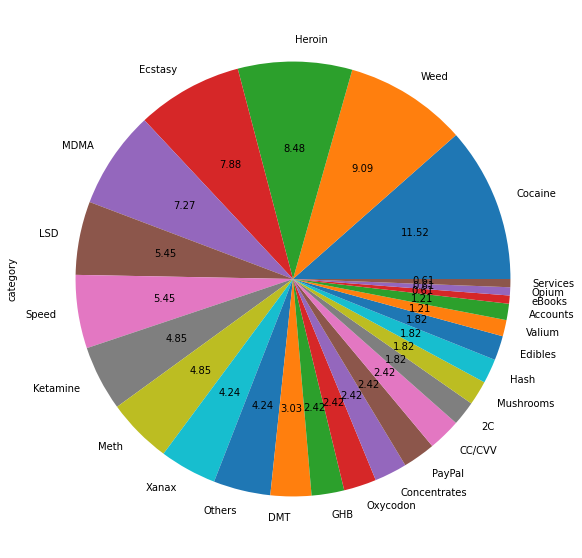

In [23]:
df['category'].value_counts().plot.pie(figsize=(10,10), autopct=lambda x: '%.2f'%x)
plt.show()

Using the `main_category`, we can now display the share of the products on the website once again. We can also show the shares of drugs:

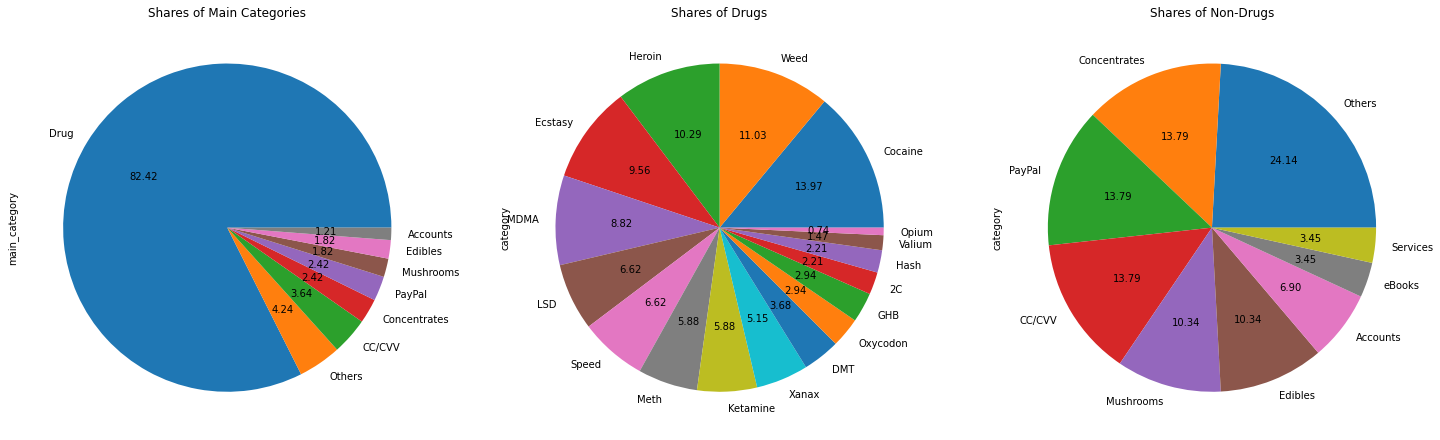

In [24]:
fig, ax = plt.subplots(1,3, figsize = (25, 15))

ax[0].title.set_text("Shares of Main Categories")
df['main_category'].value_counts().plot.pie(ax=ax[0], autopct=lambda x: '%.2f'%x)

ax[1].title.set_text("Shares of Drugs")
df[df['main_category'] == 'Drug']['category'].value_counts().plot.pie(ax=ax[1], autopct=lambda x: '%.2f'%x)

ax[2].title.set_text("Shares of Non-Drugs")
df[df['main_category'] != 'Drug']['category'].value_counts().plot.pie(ax=ax[2], autopct=lambda x: '%.2f'%x)
plt.show()

In the pie chart down below, you can also see the percentage of drugs:

## Investigating Countries

First thing we wanted to observe was the share of each country:

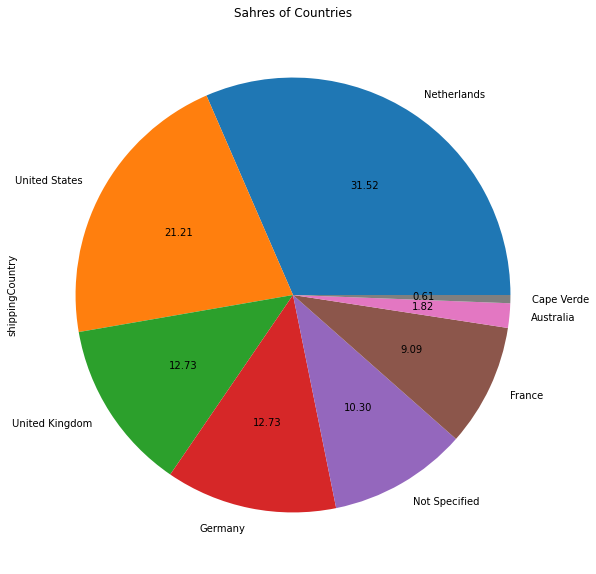

In [25]:
df['shippingCountry'].value_counts().plot.pie(figsize=(10,10), autopct=lambda x: '%.2f'%x)
plt.title("Sahres of Countries")
plt.show()

Below, we also show what products each country ships to this black market:

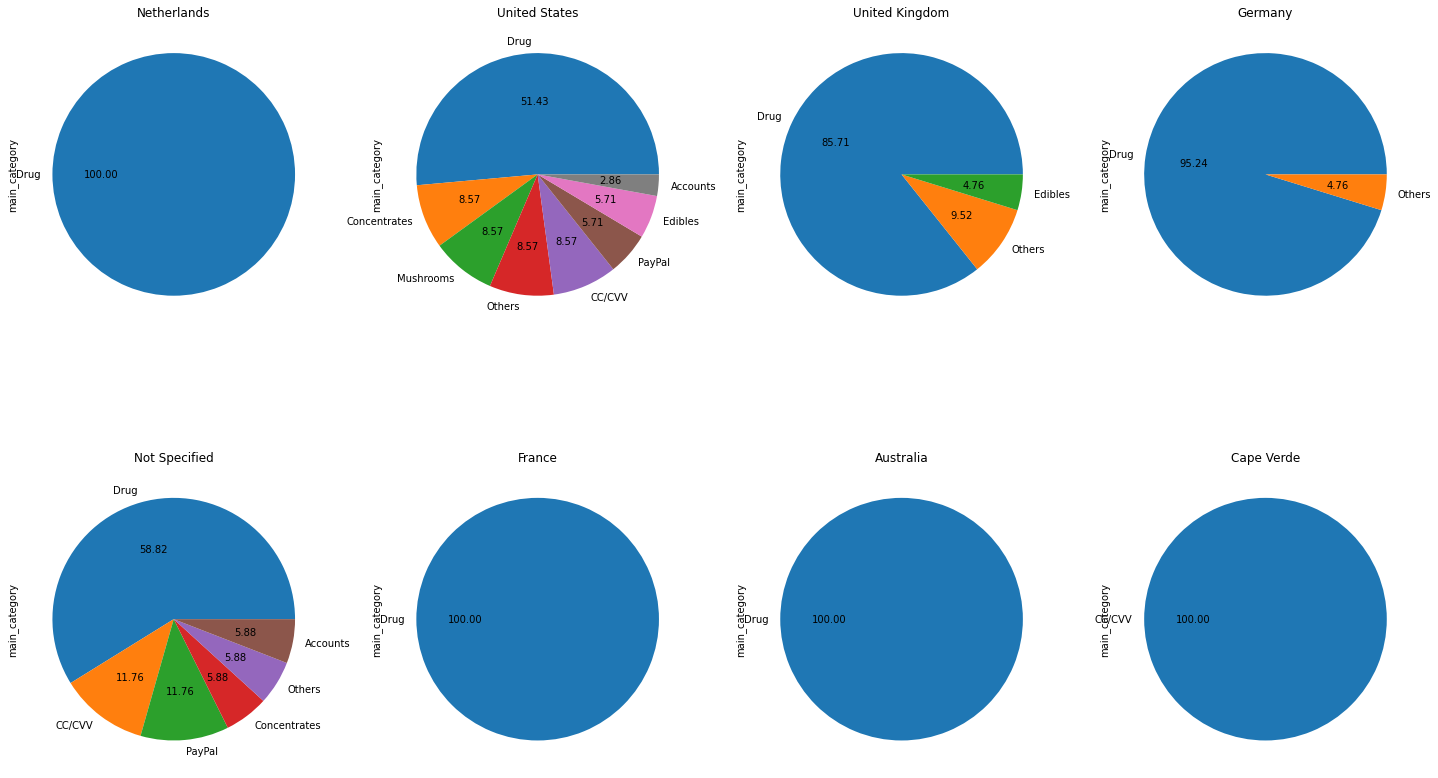

In [26]:
fig, ax = plt.subplots(2,4, figsize = (25, 15))

for i, country in enumerate(df['shippingCountry'].value_counts().index):
    ax[i//4, i%4].title.set_text(country)
    df[df['shippingCountry'] == country]['main_category'].value_counts().plot.pie(ax = ax[i//4, i%4], autopct=lambda x: '%.2f'%x)
plt.show()

## Top 10 Sellers

Before investigating the vendors, we found it beneficial to find out which vendors are the top 10 vendors. The features we generate in this section will be beneficial when we start investigating the vendors.

There are different ways of evaluating the vendors to choose the top 10. One option is to order by the number of products. Down below, you can see the top 10 vendors based on this metric. You can also see the statistics about each vendor:

In [31]:
groupedby_vendor = df.groupby('vendor').mean()
groupedby_vendor['n_products'] = df['vendor'].value_counts()
groupedby_vendor = groupedby_vendor.sort_values('n_products', ascending=False)
groupedby_vendor.head(10)

,dollars,positiveRating,negativeRating,rating,legal,n_products
vendor,,,,,,
WeAreAMSTERDAM,93.307692,28944.0,209.0,99.0,0.153846,13
Flako,34.666667,7070.0,61.0,99.0,0.000000,12
bluemagic,56.250000,18313.0,42.0,100.0,0.166667,12
MisterGreen,48.666667,1390.0,20.0,99.0,0.666667,9
JimmJoness,37.285714,1849.0,55.0,97.0,0.428571,7
Lidl,77.333333,6510.0,51.0,99.0,0.000000,6
MyINI,189.000000,22809.0,96.0,100.0,0.200000,5
theolddoctor,68.800000,1362.0,15.0,99.0,0.000000,5
marcopolo1969,23.800000,2573.0,0.0,100.0,0.600000,5


Another option is to look at the amount of reviews a vendor received, so that we can estimate which user has sold the most products.

In [32]:
groupedby_vendor['ratings'] = groupedby_vendor[['positiveRating', 'negativeRating']].sum(axis=1)
groupedby_vendor.sort_values('ratings', ascending=False).head(10)

,dollars,positiveRating,negativeRating,rating,legal,n_products,ratings
vendor,,,,,,,
WeAreAMSTERDAM,93.307692,28944.0,209.0,99.0,0.153846,13,29153.0
MyINI,189.000000,22809.0,96.0,100.0,0.200000,5,22905.0
glasshouse,10.000000,19120.0,158.0,99.0,1.000000,2,19278.0
bluemagic,56.250000,18313.0,42.0,100.0,0.166667,12,18355.0
ViceKings,60.000000,18083.0,236.0,99.0,0.000000,1,18319.0
procarder7,27.500000,13217.0,122.0,99.0,1.000000,4,13339.0
Ondemand,75.000000,8561.0,33.0,100.0,0.333333,3,8594.0
Flako,34.666667,7070.0,61.0,99.0,0.000000,12,7131.0
Lidl,77.333333,6510.0,51.0,99.0,0.000000,6,6561.0


We observe that there are 4 distinct vendors in our dataset. WeAreAMSTERDAM, Flako and bluemagic with 12 to 13 products listed in our dataset.
If we look at all the vendors we could inspect, we notice that WeAreAMSTERDAM, MyINI and glasshouse have the most reviews assigned to them, and hence are likely to be one of the biggest vendors on the platform.

Hence, if we should determine 3 vendors which the police should go after as first, it would probably be the top 3 vendors with the most ratings, since they seem the biggest fish to catch.

## Focusing on the Vendors

Distribution of the vendor ratings:

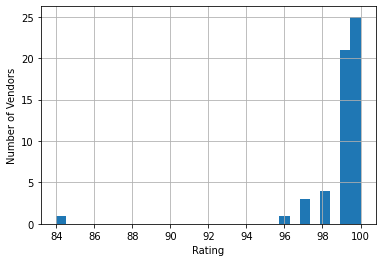

In [34]:
groupedby_vendor['rating'].hist(bins=30)
plt.ylabel("Number of Vendors")
plt.xlabel("Rating")
plt.show()

Next thing we wanted to investigate was to draw box plots to visulalize the distributions of product costs for each vendor. We decided to only use the top 10 vendors with the most products:

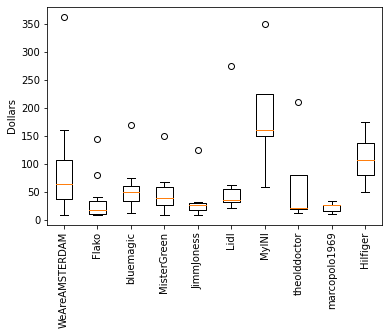

In [35]:
plt.boxplot([df[df['vendor'] == vendor]['dollars'] for vendor in groupedby_vendor.index[:10]],
    labels=groupedby_vendor.index[:10])
plt.xticks(rotation=90)
plt.ylabel("Dollars")
plt.show()

## Products that Surprised Us

We all expected to see a lot of drugs on the black market, but the following three products actually surprised us:

1) `disneyplus account`
The vendor `levelup` from the US offered a Disney+ account for $10.

2) `NETFLIX 4K UHD ACCOUNT [LIFETIME]★Auto Delivery★`
The vendor `prohack` offered an lifetime Netflix account, also for $10.

3) `2x VERIFIED Paypal Account + attached CC or BA`
The vendor `procarder7` sold PayPal accounts with a Credit Card or Bank Account attached to it, for $15.

We were surprised by number 1 and 2 because we did not really expect this on the black market, and we were also kind of curious how they could guarantee that it was a lifetime account. To us, it seemed very likely that it is a comprimised account still attached to someone bank account, but just does not use it actively anymore. So, the question then is if it actually is yours for lifetime or not.

The last product that surprised us where the verified PayPal accounts being offered. It only costs $15 dollars and there were even more entries listed which also sold PayPal accounts. We could not really imagine that this would actually work, since the Credit Card or Bank Account where this PayPal account is attached to will ofcourse see the transactions being made with it, and hence think at sometime that there has been suspicious activity, and then unlinking the PayPal account. We also did not really expect this here on the black market.

## Conclusion
We have learnt a lot about the black market by performing this analysis. It was very educational and impressive to see how many illegal items are being sold on the black market. Using all the research we have performed, we could draw the following conclusions

1) How does the black market work exactly?
The black market uses the Tor network to anonymously provide vendors and customers a marketplace where they can purchase illegal items. All purchases are made using cryptocurrency, which makes the payment also a lot more anonymous.

2) Which items are offered on the black market?
The black market mostly offers drugs: from marijuana to cocaïne, from psychadelics to painkillers: almost every category you could imagine is sold there. To our surpise, also accounts to services like Netflix, Disney+ and PayPal are sold on the platform, as well as regular Credit Card information.

3) What is the legality of the items offered on the black market?
-- insert statistics about the legality here --
